In [0]:
library(BayesLCA)
library(jsonlite)
library(mclust)
library(zoo)
library(MCMCpack)
library(readr)
library("ggplot2")
library("readr")
library(reshape)
#library(plotly)
# library(olsrr)

Loading required package: e1071

Loading required package: coda

Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2020 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##



In [0]:
install.packages('BayesLCA')
install.packages('mclust')
install.packages('zoo')
install.packages('reshape')
# # install.packages('olsrr')
# install.packages("brms")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotCall64’, ‘SparseM’, ‘MatrixModels’, ‘spam’, ‘maps’, ‘mcmc’, ‘quantreg’, ‘e1071’, ‘coda’, ‘fields’, ‘MCMCpack’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
df <- read.csv("winemag-data-130k-v2.csv")

In [0]:
sauvignon_blanc <- df[(df$country == "South Africa") & (df$variety == "Sauvignon Blanc") &(df$price ==15),]


In [0]:
chardonnay <- df[(df$country == "Chile") & (df$variety == "Chardonnay") & (df$price == 15),]

In [0]:
sauvignon_blanc <- dplyr::select(sauvignon_blanc, variety, points)
sauvignon_blanc <- sauvignon_blanc[complete.cases(sauvignon_blanc), ]

In [0]:
chardonnay <- dplyr::select(chardonnay, variety, points)
chardonnay <- chardonnay[complete.cases(chardonnay), ]

In [0]:
df2 <-rbind(sauvignon_blanc , chardonnay)

In [0]:
df2

,variety,points
,<fct>,<int>
8593,Sauvignon Blanc,89
10446,Sauvignon Blanc,85
12281,Sauvignon Blanc,90
21324,Sauvignon Blanc,86
25693,Sauvignon Blanc,88
30850,Sauvignon Blanc,87
33182,Sauvignon Blanc,87
45088,Sauvignon Blanc,87
53891,Sauvignon Blanc,85


In [0]:
df2$variety <- factor(df2$variety)
nlevels(df2$variety)

[1] 2

Warning message:
“Use of `df2$variety` is discouraged. Use `variety` instead.”


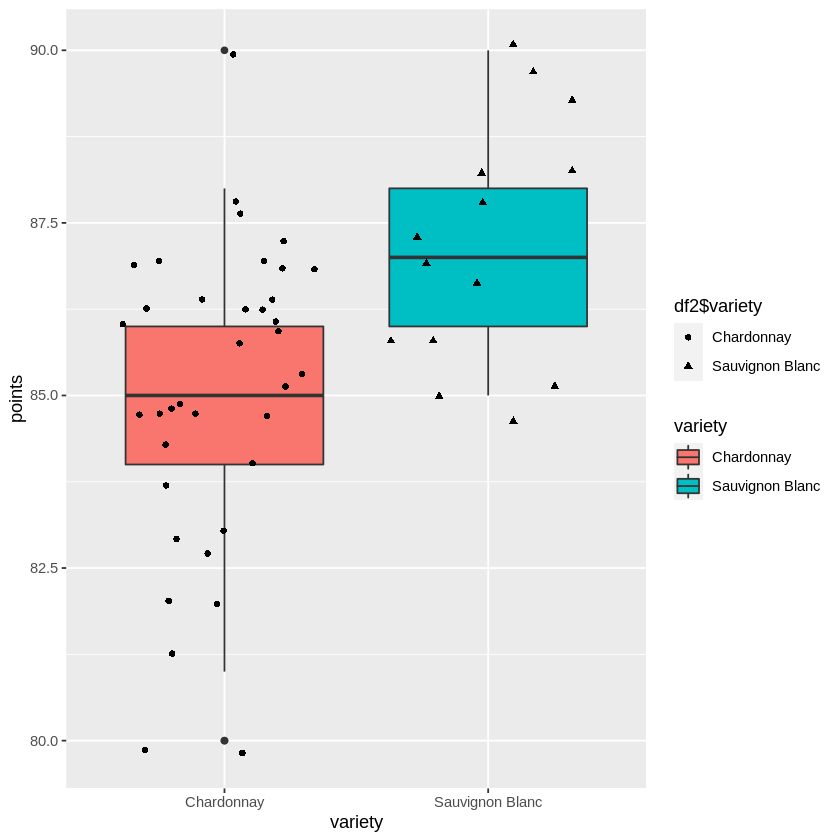

In [0]:
# ggplot(df2) + geom_boxplot(aes(x = reorder(variety, points, median), points,
# fill = reorder(variety, points, median)), show.legend=FALSE)
ggplot(df2) + geom_boxplot(aes(variety, points, fill = variety)) + geom_jitter(aes(variety, points, shape = df2$variety))

In [0]:
tapply(df2$points, df2$variety, mean)

Chardonnay Sauvignon Blanc 
       85.08108        87.21429

In [0]:
tapply(df2$points, df2$variety, median)

Chardonnay Sauvignon Blanc 
             85              87

In [0]:
tapply(df2$points, df2$variety, sd)

Chardonnay Sauvignon Blanc 
       2.203260        1.717716

In [0]:
help(t.test)

In [0]:
bartlett.test(points ~ variety, data = df2)


	Bartlett test of homogeneity of variances

data:  points by variety
Bartlett's K-squared = 1.0591, df = 1, p-value = 0.3034


In [0]:
t_test <- t.test(points ~ variety, data=df2, var.equal = T)

In [0]:
library(broom)
library(dplyr)


Attaching package: ‘dplyr’


The following object is masked from ‘package:reshape’:

    rename


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [0]:
t_test


	Two Sample t-test

data:  points by variety
t = -3.2599, df = 49, p-value = 0.00203
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.4482245 -0.8181847
sample estimates:
     mean in group Chardonnay mean in group Sauvignon Blanc 
                     85.08108                      87.21429 


In [0]:
t_test_eq_tidy <- tidy(t_test) %>% 
  # Calculate difference in means, since t.test() doesn't actually do that
  mutate(estimate = estimate1 - estimate2) %>%
  # Rearrange columns
  select(starts_with("estimate"), everything())

t_test_eq_tidy

estimate1,estimate2,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
85.08108,87.21429,-2.133205,-3.259901,0.002030174,49,-3.448225,-0.8181847,Two Sample t-test,two.sided


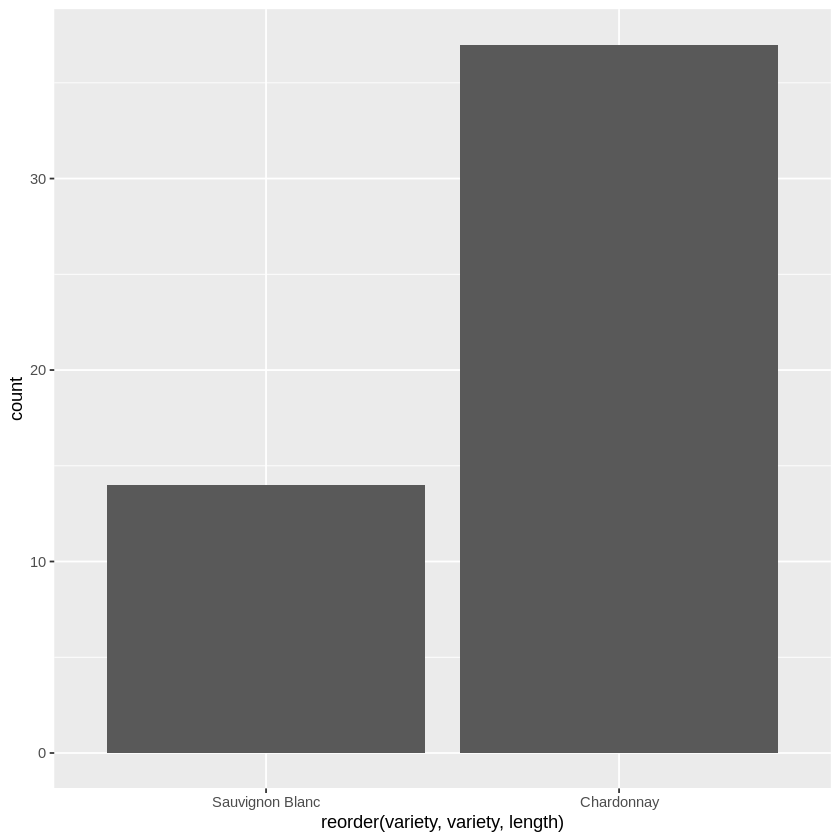

In [0]:
ggplot(df2, aes(x = reorder(variety, variety, length))) + stat_count()

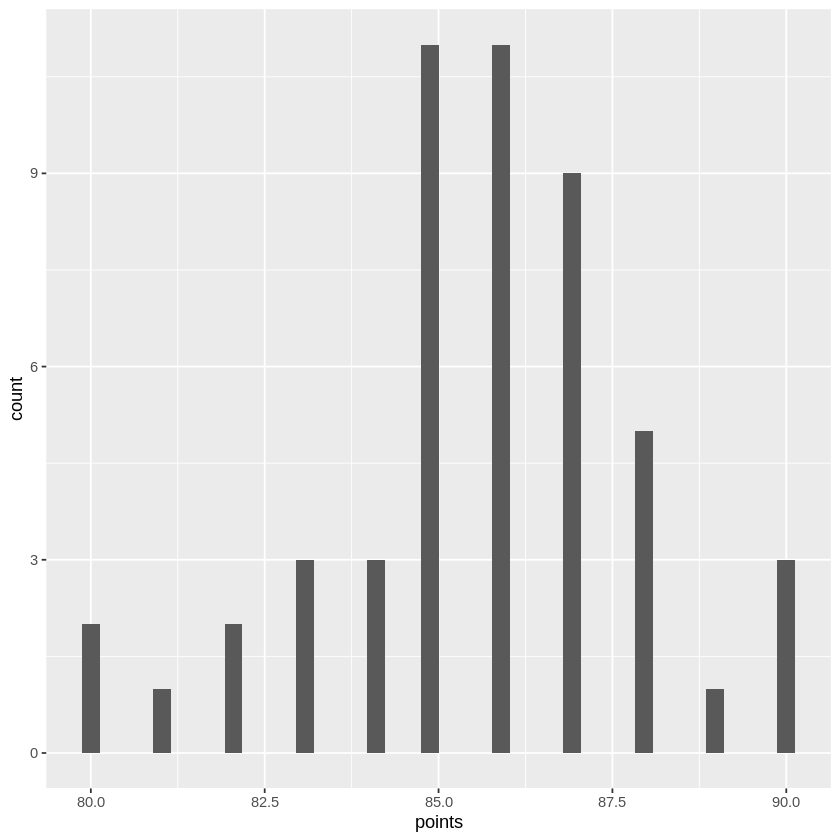

In [0]:
ggplot(df2, aes(points)) + stat_bin(bins = 40)

In [0]:
compare_2_gibbs <- function(y, ind, mu0 = 8, tau0 = 1/400, del0 = 0, gamma0 = 1/400,
a0 = 1, b0 = 5, maxiter = 10000)
{
y1 <- y[ind == 'Chardonnay']
print(y1)
y2 <- y[ind == 'Sauvignon Blanc']
n1 <- length(y1)
n2 <- length(y2)
print(n1)
print(n2)
##### starting values
mu <- (mean(y1) + mean(y2)) / 2
del <- (mean(y1) - mean(y2)) / 2
mat_store <- matrix(0, nrow = maxiter, ncol = 3)
#####
##### Gibbs sampler
an <- a0 + (n1 + n2)/2
for(s in 1 : maxiter)
{
##update tau
bn <- b0 + 0.5 * (sum((y1 - mu - del) ^ 2) + sum((y2 - mu + del) ^ 2))
tau <- rgamma(1, an, bn)
##
##update mu
taun <- tau0 + tau * (n1 + n2)
mun <- (tau0 * mu0 + tau * (sum(y1 - del) + sum(y2 + del))) / taun
mu <- rnorm(1, mun, sqrt(1/taun))
##
##update del
gamman <- tau0 + tau*(n1 + n2)
deln <- ( del0 * tau0 + tau * (sum(y1 - mu) - sum(y2 - mu))) / gamman
del<-rnorm(1, deln, sqrt(1/gamman))
##
## store parameter values
mat_store[s, ] <- c(mu, del, tau)
}
colnames(mat_store) <- c("mu", "del", "tau")
return(mat_store)
}

In [0]:
as.factor(df2$variety)

[1] Sauvignon Blanc Sauvignon Blanc Sauvignon Blanc Sauvignon Blanc
 [5] Sauvignon Blanc Sauvignon Blanc Sauvignon Blanc Sauvignon Blanc
 [9] Sauvignon Blanc Sauvignon Blanc Sauvignon Blanc Sauvignon Blanc
[13] Sauvignon Blanc Sauvignon Blanc Chardonnay      Chardonnay     
[17] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[21] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[25] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[29] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[33] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[37] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[41] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[45] Chardonnay      Chardonnay      Chardonnay      Chardonnay     
[49] Chardonnay      Chardonnay      Chardonnay     
Levels: Chardonnay Sauvignon Blanc

In [0]:
fit <- compare_2_gibbs(df2$points, as.factor(df2$variety))

 [1] 85 83 80 82 85 83 85 87 85 84 87 86 87 85 85 87 88 87 86 86 85 81 90 80 86
[26] 85 86 84 86 84 83 87 88 86 82 86 86
[1] 37
[1] 14


In [0]:
fit_thin <- fit[2*(1:5000),]

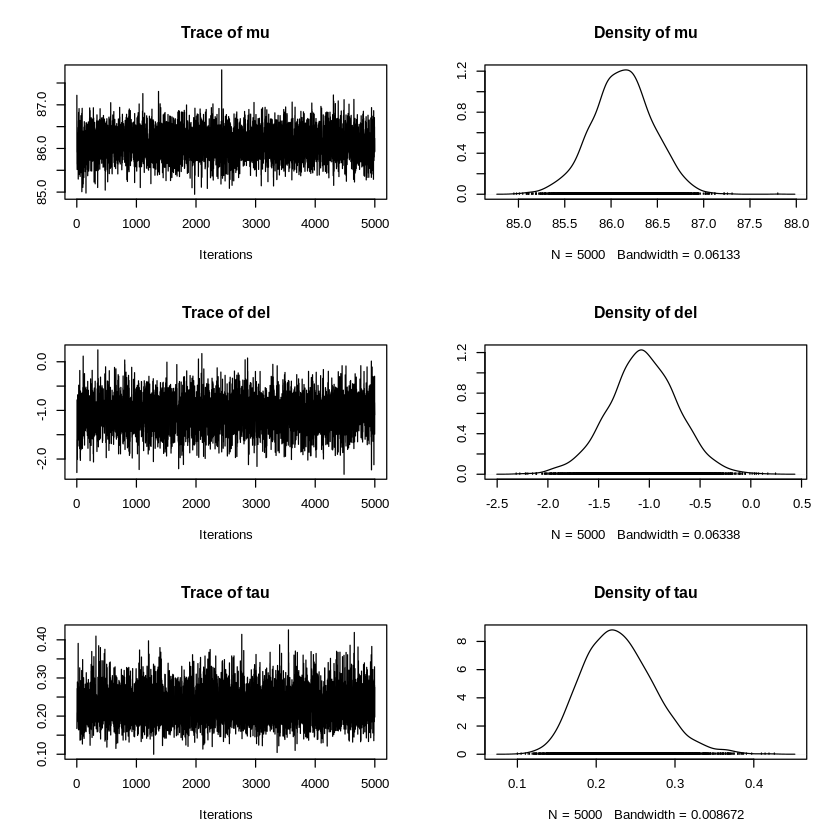

In [0]:
fit.mcmc <- as.mcmc(fit_thin)
plot(fit.mcmc)


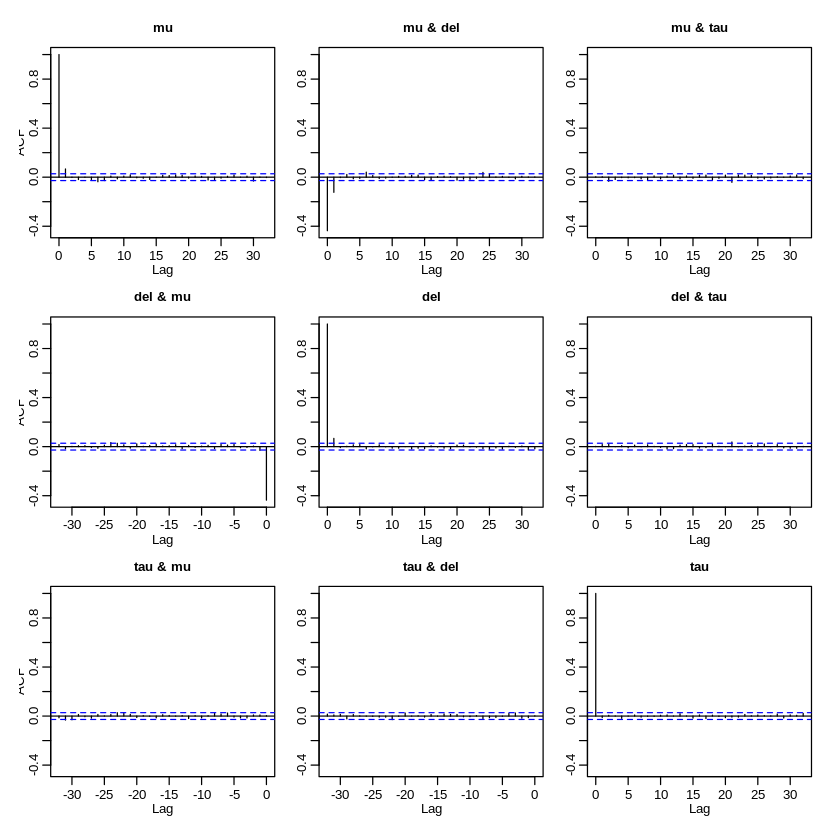

In [0]:
acf(fit.mcmc)

In [0]:
raftery.diag(as.mcmc(fit_thin))


Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                           
     Burn-in  Total Lower bound  Dependence
     (M)      (N)   (Nmin)       factor (I)
 mu  2        3680  3746         0.982     
 del 2        3774  3746         1.010     
 tau 2        3741  3746         0.999     


In [0]:
apply(fit_thin, 2, mean)

mu        del        tau 
86.1239530 -1.0603836  0.2290241

In [0]:
apply(fit_thin, 2, sd)

mu        del        tau 
0.32834458 0.33889174 0.04493513

In [0]:
mean(1/sqrt(fit_thin[, 3]))

[1] 2.120046

In [0]:
sd(1/sqrt(fit_thin[, 3]))

[1] 0.2106487

In [0]:
y1_sim <- rnorm(5000, fit_thin[, 1] + fit_thin[, 2], sd = 1/sqrt(fit_thin[, 3]))
y2_sim <- rnorm(5000, fit_thin[, 1] - fit_thin[, 2], sd = 1/sqrt(fit_thin[, 3]))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



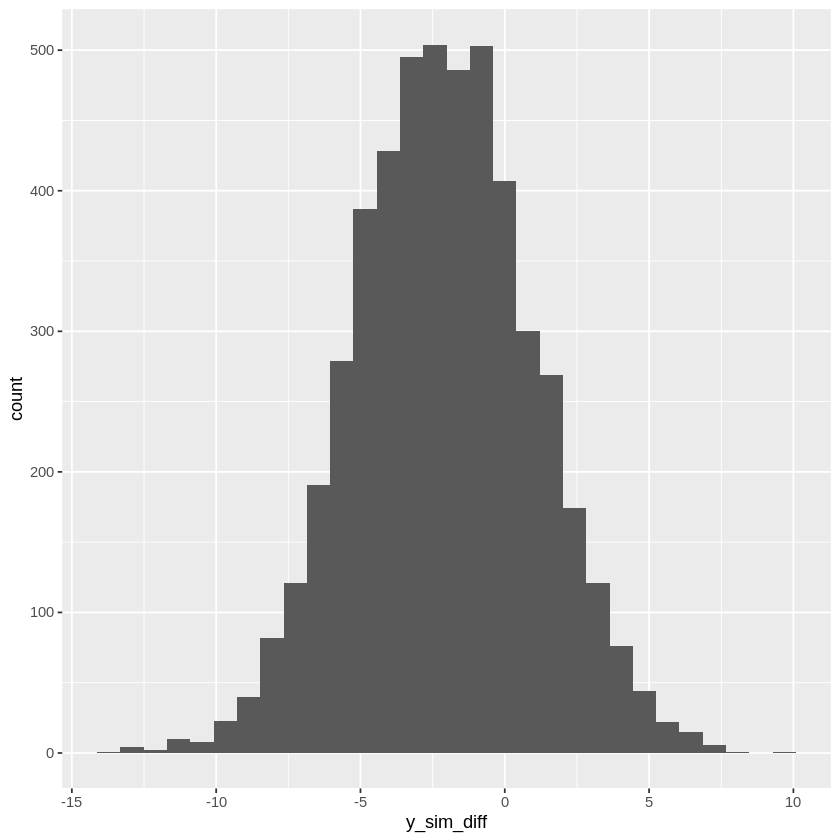

In [0]:
ggplot(data.frame(y_sim_diff = y1_sim - y2_sim)) + stat_bin(aes(y_sim_diff))


In [0]:
help(lm)

In [0]:
olsmod <- lm(formula = points ~ variety, data = df2)

In [0]:
summary(olsmod)


Call:
lm(formula = points ~ variety, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0811 -1.1477 -0.0811  0.9189  4.9189 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             85.0811     0.3429  248.16  < 2e-16 ***
varietySauvignon Blanc   2.1332     0.6544    3.26  0.00203 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.085 on 49 degrees of freedom
Multiple R-squared:  0.1782,	Adjusted R-squared:  0.1615 
F-statistic: 10.63 on 1 and 49 DF,  p-value: 0.00203


In [0]:
install.packages('brms')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘httpuv’, ‘sourcetools’, ‘fastmap’, ‘miniUI’, ‘packrat’, ‘igraph’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘RcppEigen’, ‘checkmate’, ‘ggridges’, ‘shiny’, ‘colourpicker’, ‘dygraphs’, ‘gtools’, ‘rsconnect’, ‘shinyjs’, ‘shinythemes’, ‘threejs’, ‘xtable’, ‘xts’, ‘mvtnorm’, ‘Brobdingnag’, ‘globals’, ‘listenv’, ‘rstan’, ‘loo’, ‘rstantools’, ‘bayesplot’, ‘shinystan’, ‘bridgesampling’, ‘matrixStats’, ‘nleqslv’, ‘abind’, ‘future’




In [0]:
library(brms)
mod_eqvar <- brm(
  points ~ as.factor(variety), 
  data = df2,
)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '07858188239dbd12ef4021a9eaefe5e9' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.018587 seconds (Warm-up)
Chain 1:                0.012756 seconds (Sampling)


In [0]:
brms_eq_tidy <- 
  tidyMCMC(mod_eqvar, conf.int = TRUE, conf.level = 0.95, 
           estimate.method = "mean", conf.method = "HPDinterval")
brms_eq_tidy

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
b_Intercept,85.080599,0.3576174,84.346648,85.749857
b_as.factorvarietySauvignonBlanc,2.124736,0.6713136,0.780321,3.374099
sigma,2.148150,0.2252036,1.720603,2.571913


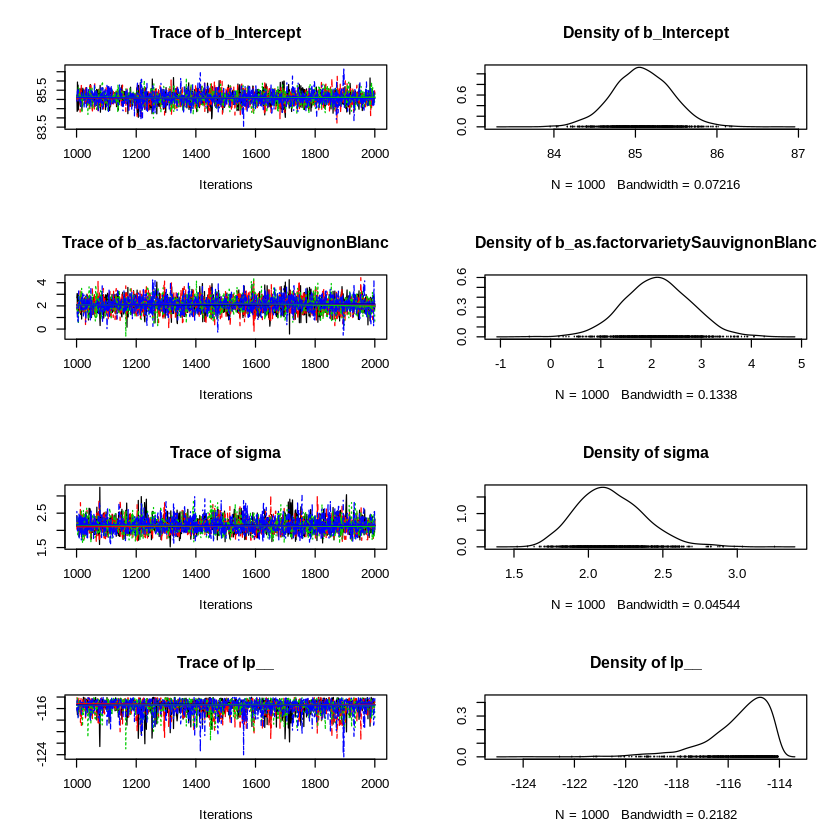

In [0]:
fit.mcmc <- as.mcmc(mod_eqvar)
plot(fit.mcmc)

In [0]:
acf(fit.mcmc)

ERROR: ignored

In [0]:
install.packages("BEST")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘HDInterval’, ‘rjags’


Warning message in install.packages("BEST"):
“installation of package ‘rjags’ had non-zero exit status”
Warning message in install.packages("BEST"):
“installation of package ‘BEST’ had non-zero exit status”


In [0]:
library(BEST)
BEST <- BESTmcmc(chardonnay$points, sauvignon_blanc$points

)

ERROR: ignored

In [0]:
help(lm)

In [0]:
mean(y1_sim < y2_sim)

[1] 0.7642

Consider the Italian wines in the dataset. Which regions
produce better than average wine? Limit your analysis to
wines costing less than €20 and to regions which have at
least four such reviews.

In [0]:
df3 = read.csv('italian_wines.csv')

In [0]:
df3 <- dplyr::select(df3, country,region_1,variety, points)
head(df3)

,country,region_1,variety,points
,<fct>,<fct>,<fct>,<int>
1,Italy,Vittoria,Frappato,87
2,Italy,Sicilia,White Blend,87
3,Italy,Terre Siciliane,White Blend,87
4,Italy,Terre Siciliane,Nero d'Avola,87
5,Italy,Cerasuolo di Vittoria,Red Blend,87
6,Italy,Puglia,Primitivo,86


In [0]:
df3$region_1 <- factor(df3$region_1)
nlevels(df3$region_1)

[1] 142

In [0]:
library(dplyr)
italian_wines <- dplyr::select(df3, region_1, points)
df3 <- italian_wines[complete.cases(italian_wines), ]


Attaching package: ‘dplyr’


The following object is masked from ‘package:reshape’:

    rename


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




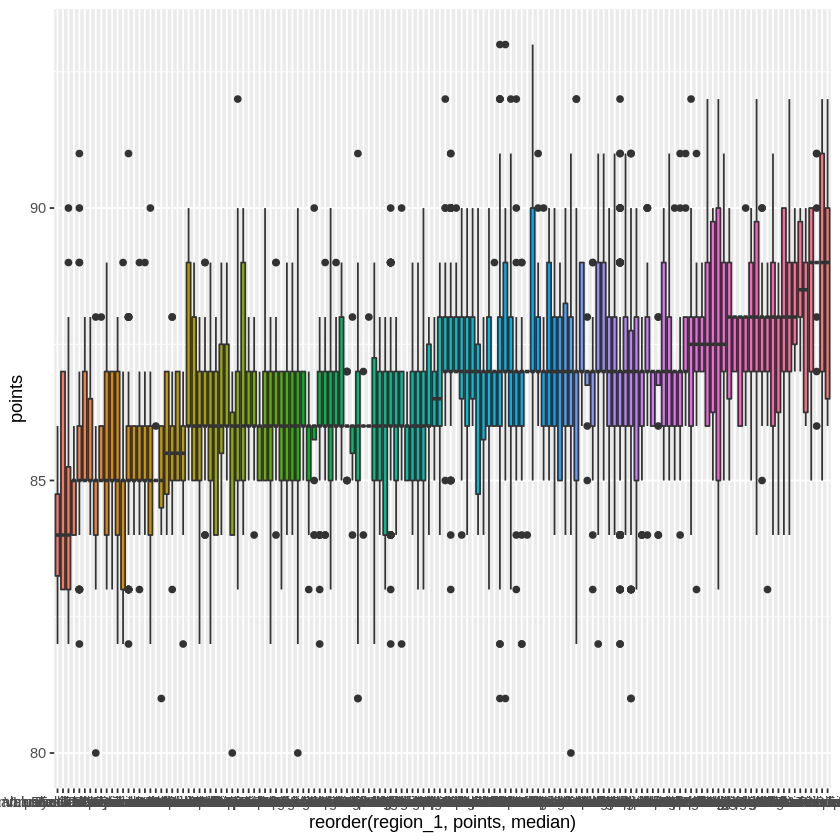

In [0]:
ggplot(df3) + geom_boxplot(aes(x = reorder(region_1, points, median), points,
fill = reorder(region_1, points, median)), show.legend=FALSE)

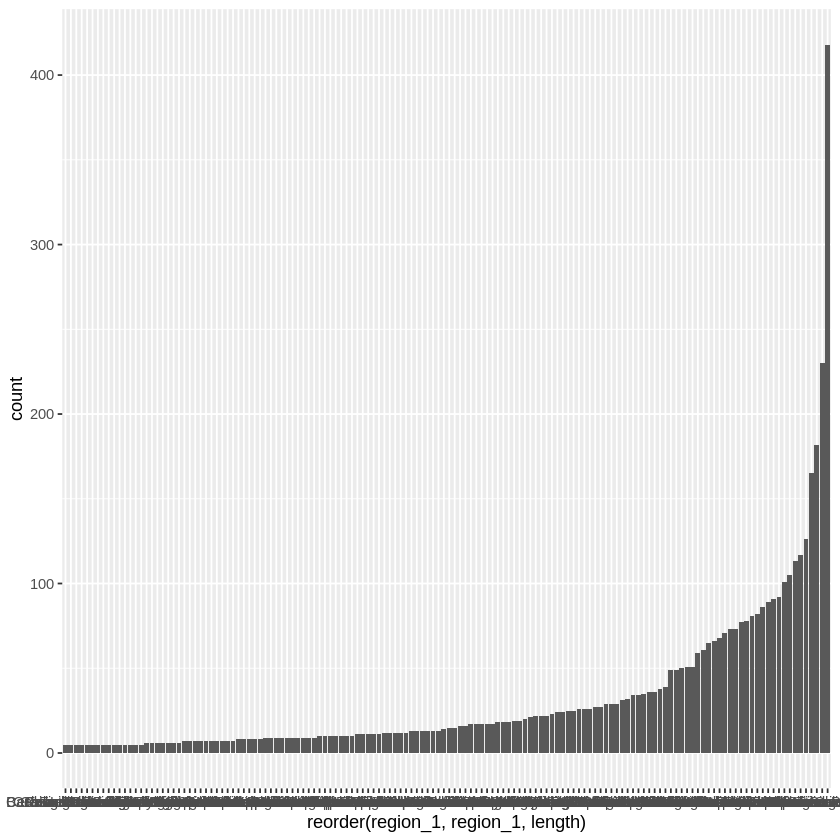

In [0]:
ggplot(df3, aes(x = reorder(region_1, region_1, length))) + stat_count()

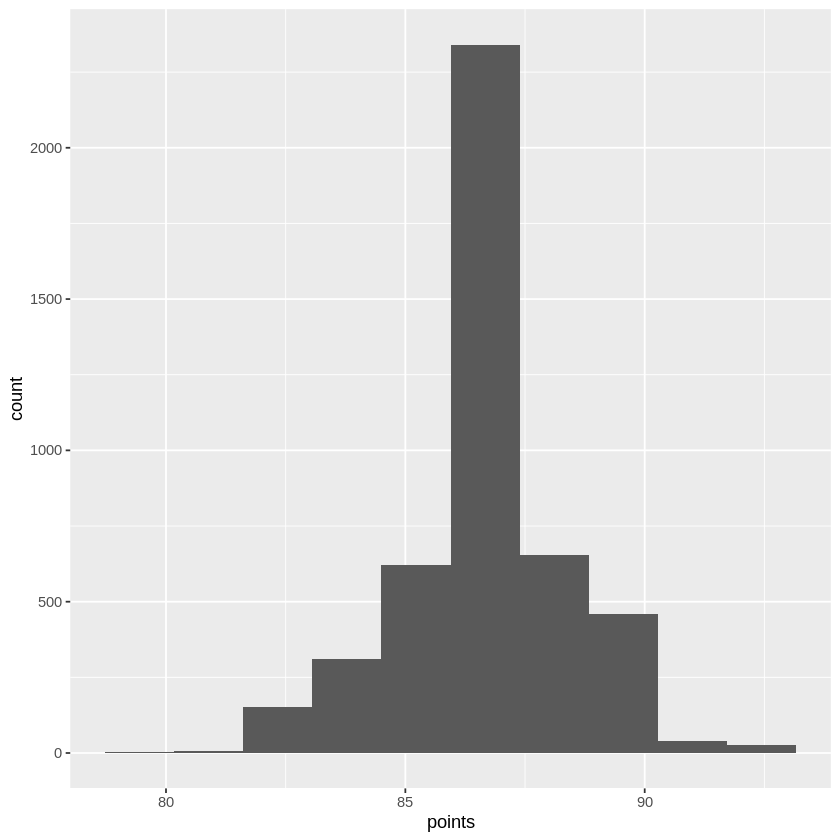

In [0]:
ggplot(df3, aes(points)) + stat_bin(bins = 10)

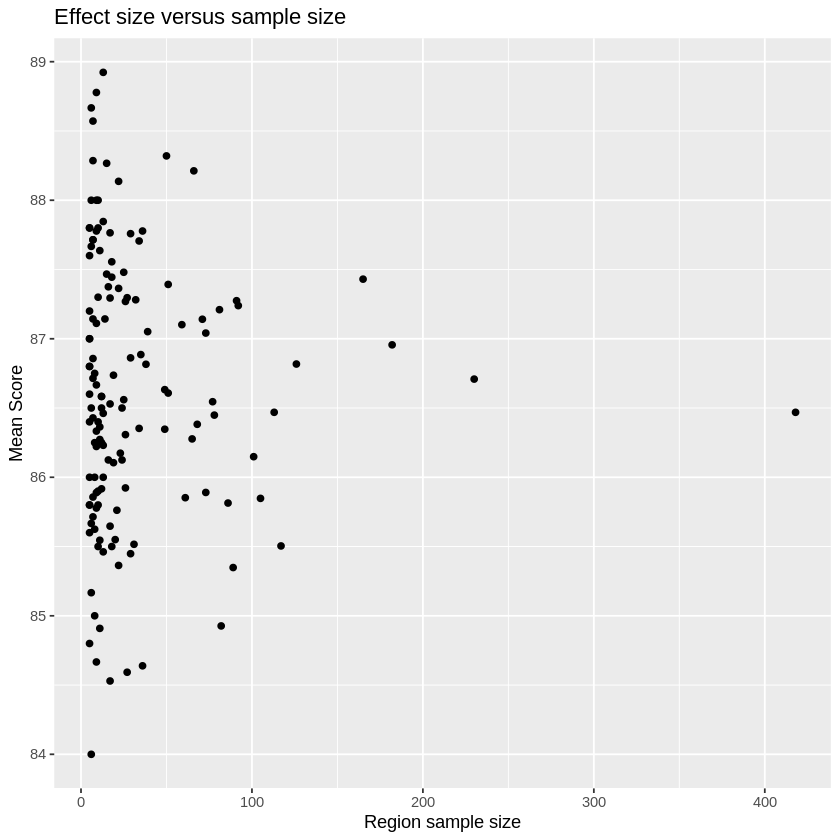

In [0]:
ggplot(data.frame(size = tapply(df3$points, df3$region_1, length),
mean_score = tapply(df3$points, df3$region_1, mean)), aes(size, mean_score)) +
geom_point() + xlab("Region sample size") + ylab("Mean Score") +
ggtitle("Effect size versus sample size")


In [0]:
compare_m_gibbs <- function(y, ind, mu0 = 50, tau0 = 1/400,
a0 = 1, b0 = 50, alpha0 =1, beta0 = 50, maxiter = 10000)
{
### weakly informative priors
a0 <- 1/2 ; b0 <- 50 ## tau_w hyperparameters
alpha0 <-1/2 ; beta0 <- 50 ## tau_b hyperparameters
mu0<-50 ; tau0 <- 1/25
###
### starting values
m <- nlevels(ind)
ybar <- theta <- tapply(y, ind, mean)
tau_w <- mean(1 / tapply(y, ind, var)) ##within group precision
mu <- mean(theta)
11
tau_b <-var(theta) ##between group precision
n_m <- tapply(y, ind, length)
alphan <- alpha0 + sum(n_m)/2
###
### setup MCMC
theta_mat <- matrix(0, nrow=maxiter, ncol=m)
mat_store <- matrix(0, nrow=maxiter, ncol=3)
###
### MCMC algorithm
for(s in 1:maxiter)
{
# sample new values of the thetas
for(j in 1:m)
{
taun <- n_m[j] * tau_w + tau_b
thetan <- (ybar[j] * n_m[j] * tau_w + mu * tau_b) / taun
theta[j]<-rnorm(1, thetan, 1/sqrt(taun))
}
#sample new value of tau_w
ss <- 0
for(j in 1:m){
ss <- ss + sum((y[ind == j] - theta[j])^2)
}
betan <- beta0 + ss/2
tau_w <- rgamma(1, alphan, betan)
#sample a new value of mu
taum <- m * tau_b + tau0
mum <- (mean(theta) * m * tau_b + mu0 * tau0) / taum
mu <- rnorm(1, mum, 1/ sqrt(taum))
# sample a new value of tau_b
am <- a0 + m/2
bm <- b0 + sum((theta - mu)^2) / 2
tau_b <- rgamma(1, am, bm)
#store results
theta_mat[s,] <- theta
mat_store[s, ] <- c(mu, tau_w, tau_b)
}
colnames(mat_store) <- c("mu", "tau_w", "tau_b")
return(list(params = mat_store, theta = theta_mat))
}


In [0]:
df3$region_1_numeric <- as.numeric(df3$region_1)

In [0]:
fit2 <- compare_m_gibbs(df3$points, factor(df3$region_1_numeric))


In [0]:
fit2$theta[2*(1:5000),]

86.84425,87.29080,87.63599,87.43940,85.23289,87.30909,85.56676,87.28113,86.97432,86.72424,⋯,87.96434,87.77575,87.92791,87.75539,87.03227,86.52337,86.47664,86.87739,86.68486,88.19935
87.92903,87.37788,87.41362,86.84541,85.21337,87.26105,86.62438,87.39926,87.23082,87.56418,⋯,87.91545,88.02235,87.86100,87.57873,87.33177,87.37414,86.81728,87.36667,86.59655,87.48342
88.10298,87.54897,88.03261,88.45423,84.41212,86.76158,85.75369,86.93278,87.36124,87.21203,⋯,87.82886,88.52986,88.52398,86.87699,87.07342,87.11245,86.85824,87.97138,85.93228,88.61772
87.84800,87.42296,87.18900,86.50763,85.02935,86.80282,86.50154,87.07492,86.93482,87.99797,⋯,87.62176,87.89642,88.55196,87.11710,87.30984,86.36048,87.10880,87.69723,86.21227,86.86003
87.39132,87.44998,87.61403,87.03296,84.96958,86.72380,86.43500,87.04659,87.36332,87.47983,⋯,87.83755,88.31632,88.40803,87.69127,87.05887,86.28737,86.48990,87.66490,86.09080,87.92959
87.71583,87.34934,87.94176,87.25708,84.78943,87.27359,86.54988,87.14461,86.98227,87.09340,⋯,87.52598,88.73108,88.67413,87.33806,87.16841,87.02998,86.89479,88.72705,86.43819,87.96414
88.22718,87.21002,87.16883,86.91886,84.69573,86.95863,86.99171,86.61411,86.92769,87.89125,⋯,87.83842,87.80763,88.27188,86.96826,87.21950,86.04493,86.66451,87.80764,86.91321,87.84105
87.72521,87.23811,87.39757,86.38717,85.94957,86.33624,86.88303,87.14614,87.31270,87.49321,⋯,87.92330,89.45859,87.92930,87.45182,87.03511,87.33681,86.92567,86.92686,86.58615,87.78302
88.22950,87.43111,86.94297,87.80087,84.42207,86.77280,86.30403,87.36895,87.18738,87.35079,⋯,87.85406,88.11589,88.76503,87.52820,86.89718,86.61752,86.69404,87.41197,86.85332,87.89706
88.16488,87.41418,87.50906,87.18682,85.03484,86.74784,86.58625,87.10201,87.15067,87.04284,⋯,87.41180,88.43691,88.32638,86.84102,86.99836,86.65767,87.09516,87.46716,86.77604,88.01531
87.27538,87.45760,87.20707,87.89110,85.22048,87.08150,87.10418,86.82552,87.45336,87.29108,⋯,87.92658,87.75624,87.70191,87.64135,87.05720,87.27396,86.85669,87.40830,86.37791,88.03672


In [0]:
fit2$theta <- fit2$theta[2*(1:5000),]
fit2$params <- fit2$params[2*(1:5000),]

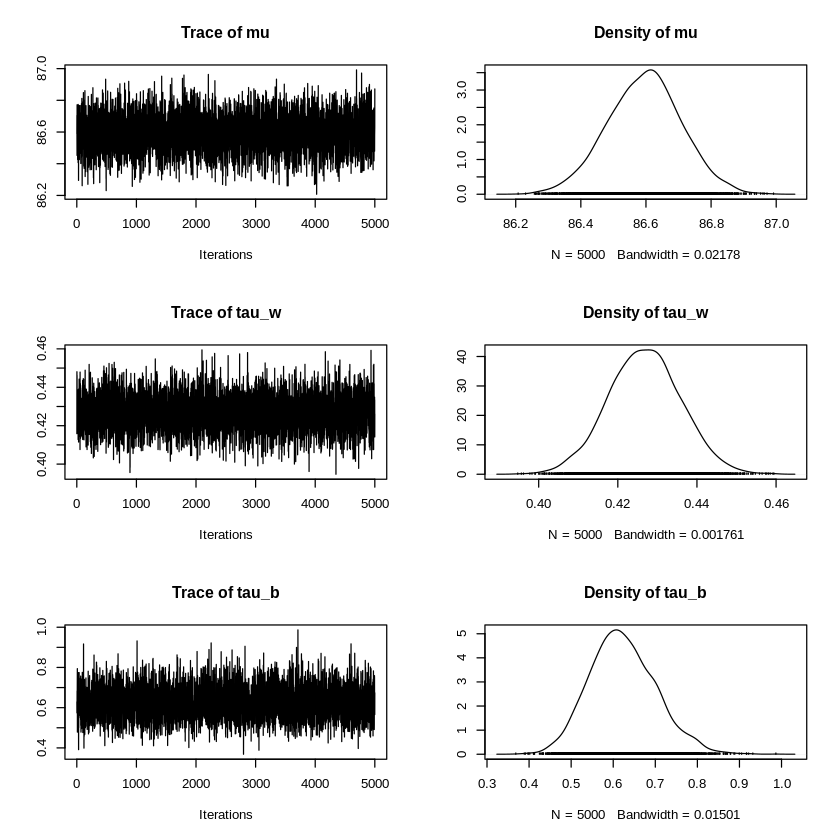


Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin)       factor (I)
 mu    2        3866  3746         1.030     
 tau_w 2        3680  3746         0.982     
 tau_b 2        3680  3746         0.982     


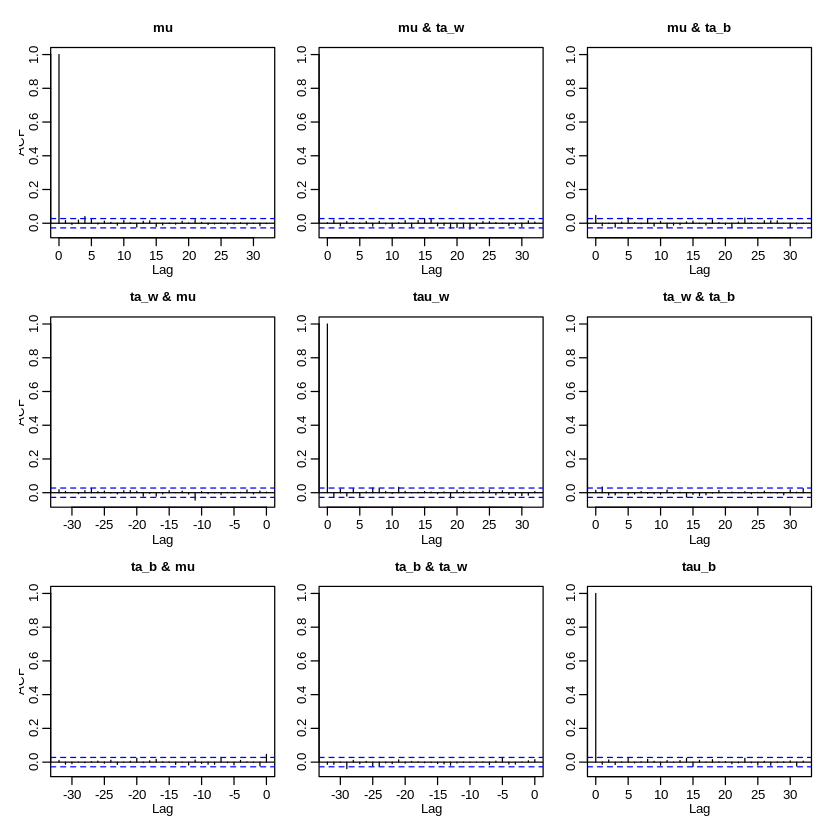

In [0]:
fit.mcmc <- as.mcmc(fit2$params)
plot(fit.mcmc)
acf(fit.mcmc)
raftery.diag(as.mcmc(fit2$params))

In [0]:
apply(fit2$params, 2, mean)

mu      tau_w      tau_b 
86.5955993  0.4267956  0.6229063

In [0]:
apply(fit2$params, 2, sd)


mu      tau_w      tau_b 
0.11326311 0.00917392 0.07842371

In [0]:
mean(1/sqrt(fit2$params[, 2]))

[1] 1.530965

In [0]:
sd(1/sqrt(fit2$params[, 2]))

[1] 0.01646132

In [0]:
mean(1/sqrt(fit2$params[, 3]))

[1] 1.274582

In [0]:
sd(1/sqrt(fit2$params[, 3]))

[1] 0.08053452

In [0]:
datasim=as.data.frame(fit2$theta)

datasim$ID <- seq.int(nrow(datasim))

In [0]:
head(datasim)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V134,V135,V136,V137,V138,V139,V140,V141,V142,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,86.84425,87.29080,87.63599,87.43940,85.23289,87.30909,85.56676,87.28113,86.97432,86.72424,⋯,87.77575,87.92791,87.75539,87.03227,86.52337,86.47664,86.87739,86.68486,88.19935,1
2,87.92903,87.37788,87.41362,86.84541,85.21337,87.26105,86.62438,87.39926,87.23082,87.56418,⋯,88.02235,87.86100,87.57873,87.33177,87.37414,86.81728,87.36667,86.59655,87.48342,2
3,88.10298,87.54897,88.03261,88.45423,84.41212,86.76158,85.75369,86.93278,87.36124,87.21203,⋯,88.52986,88.52398,86.87699,87.07342,87.11245,86.85824,87.97138,85.93228,88.61772,3
4,87.84800,87.42296,87.18900,86.50763,85.02935,86.80282,86.50154,87.07492,86.93482,87.99797,⋯,87.89642,88.55196,87.11710,87.30984,86.36048,87.10880,87.69723,86.21227,86.86003,4
5,87.39132,87.44998,87.61403,87.03296,84.96958,86.72380,86.43500,87.04659,87.36332,87.47983,⋯,88.31632,88.40803,87.69127,87.05887,86.28737,86.48990,87.66490,86.09080,87.92959,5
6,87.71583,87.34934,87.94176,87.25708,84.78943,87.27359,86.54988,87.14461,86.98227,87.09340,⋯,88.73108,88.67413,87.33806,87.16841,87.02998,86.89479,88.72705,86.43819,87.96414,6


In [0]:
theta_hat <- apply(fit2$theta, 2, mean) 
names(theta_hat) <- sort(unique(df3$region_1))
region_avg<-(sort(theta_hat, decreasing = TRUE)) 

In [0]:
mean(region_avg)

[1] 86.61006

In [0]:
region_avg <- data.frame(average= region_avg)


In [0]:
region_avg<- tibble::rownames_to_column(region_avg, "region")

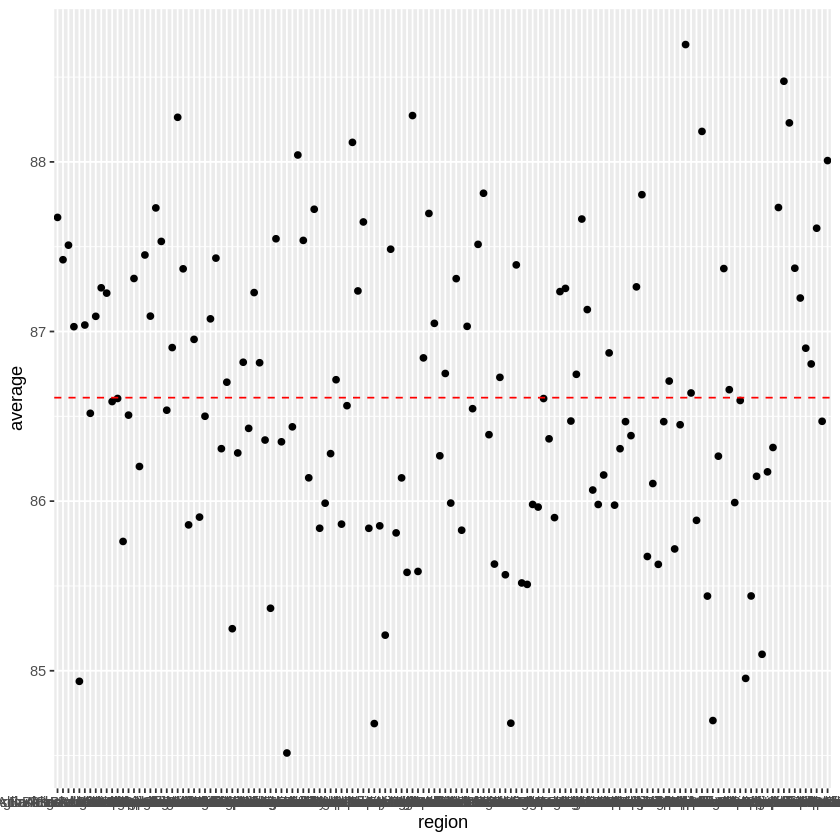

In [0]:
ggplot(region_avg, aes(x=region, y=average)) + geom_point() +
  geom_hline(yintercept=86.61, linetype="dashed", color = "red")

In [0]:
  print(region_avg[region_avg$average>86.61,])

                                               region  average
1                                              Trento 88.69180
2                              Verdicchio di Matelica 88.47549
3                                              Lugana 88.27322
4                      Cerasuolo di Vittoria Classico 88.26289
5                               Vermentino di Gallura 88.23001
6                    Valdobbiadene Prosecco Superiore 88.17971
7                                       Greco di Tufo 88.11511
8                                                Etna 88.04068
9                                            Vittoria 88.00775
10                                    Offida Pecorino 87.81512
11                           Soave Classico Superiore 87.80678
12 Verdicchio dei Castelli di Jesi Classico Superiore 87.73107
13                               Carignano del Sulcis 87.72868
14                                  Fiano di Avellino 87.72080
15                                    Maremma Toscana 8

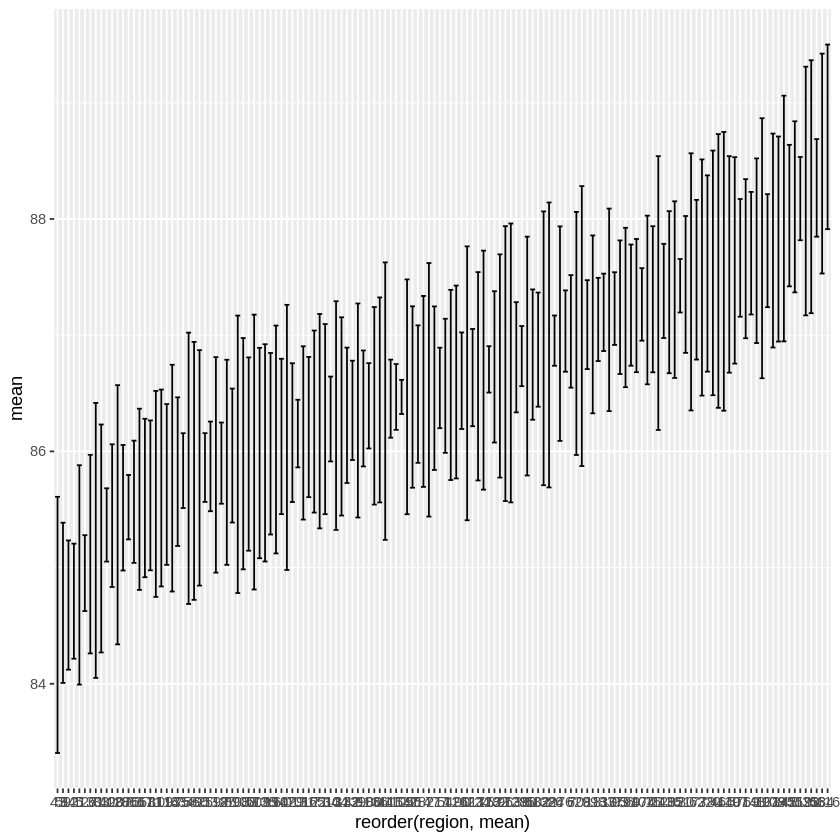

In [0]:
theta_ci <- apply(fit2$theta, 2, quantile, prob = c(0.025, .975)) ## upper/lower bounds for thetas
df_error <- data.frame(lower = theta_ci[1, ], upper = theta_ci[2, ], mean = theta_hat,
region = factor(1:142))
ggplot(df_error, aes(x = reorder(region, mean), mean)) + geom_errorbar(aes(ymin = lower, ymax = upper))

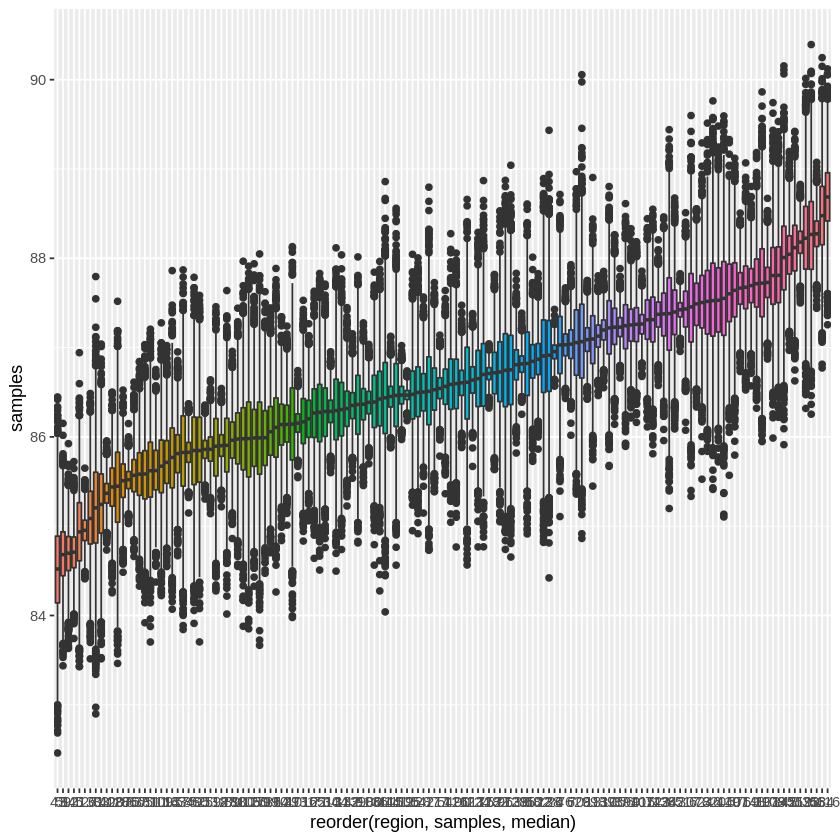

In [0]:
## reformat samples for ggplot
theta_df <- data.frame(samples = as.numeric(fit2$theta),
region = rep(1:ncol(fit2$theta), each = nrow(fit2$theta)))
ggplot(theta_df) + geom_boxplot(aes(x = reorder(region, samples, median), samples,
fill = reorder(region, samples, median)), show.legend=FALSE)

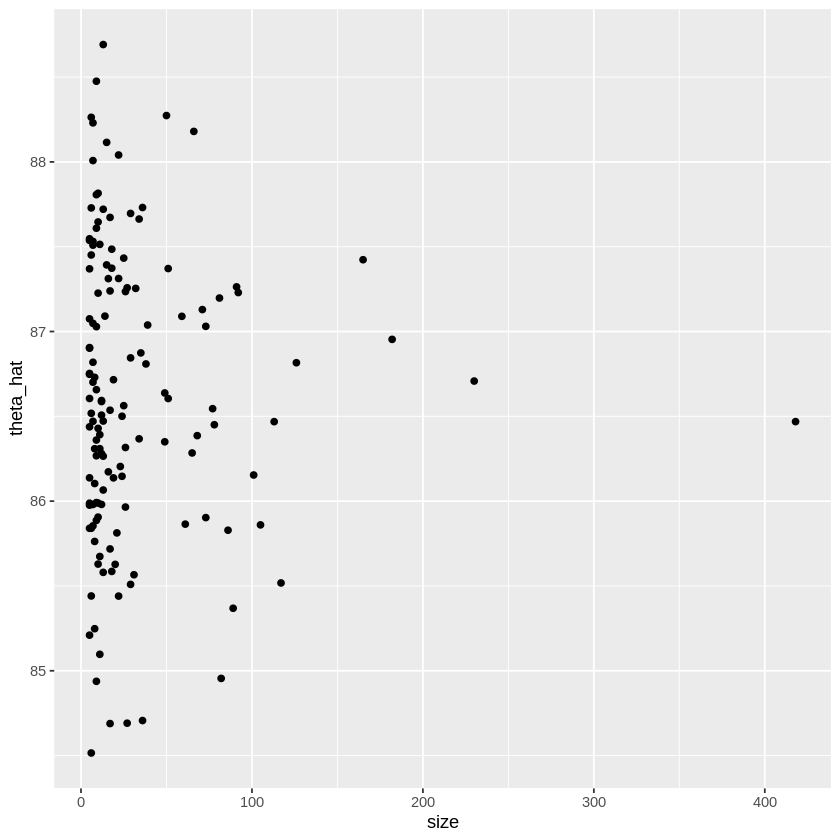

In [0]:
ggplot(data.frame(size = tapply(df3$points, df3$region_1, length), theta_hat = theta_hat),
aes(size, theta_hat)) + geom_point()

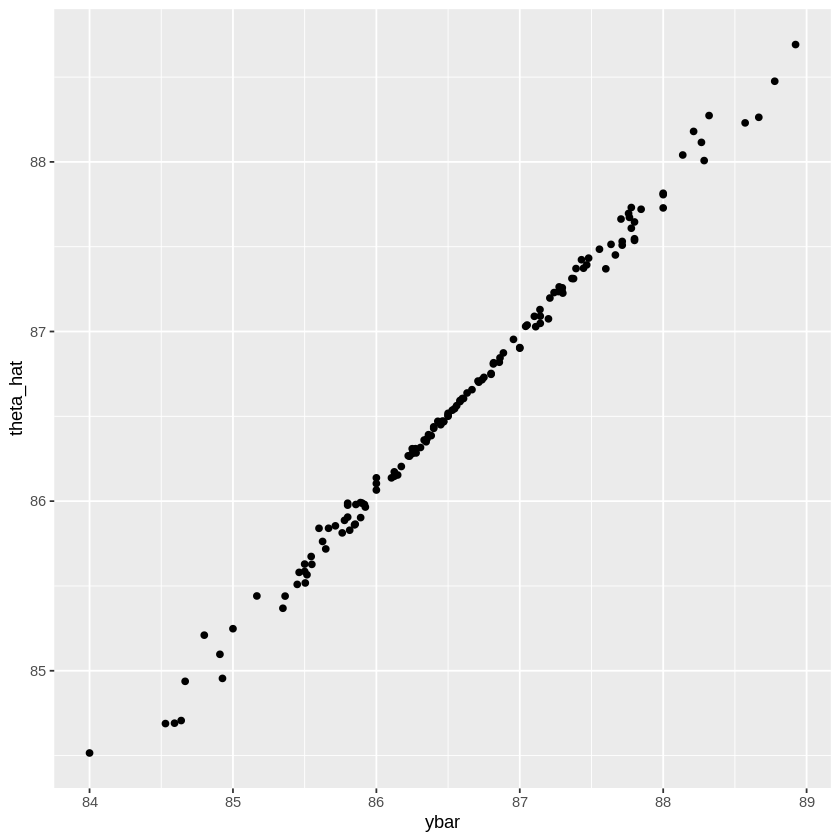

In [0]:
ggplot(data.frame(ybar = tapply(df3$points, df3$region_1, mean), theta_hat = theta_hat),
aes(ybar, theta_hat)) + geom_point()


In [0]:
theta_df

samples,region
<dbl>,<int>
86.84425,1
87.92903,1
88.10298,1
87.84800,1
87.39132,1
87.71583,1
88.22718,1
87.72521,1
88.22950,1


In [0]:
apply(fit$theta, 2, mean)

ERROR: Error in fit$theta: $ operator is invalid for atomic vectors


In [0]:
df2

,variety,points
8593,Sauvignon Blanc,89
10446,Sauvignon Blanc,85
12281,Sauvignon Blanc,90
21324,Sauvignon Blanc,86
25693,Sauvignon Blanc,88
30850,Sauvignon Blanc,87
33182,Sauvignon Blanc,87
45088,Sauvignon Blanc,87
53891,Sauvignon Blanc,85
61746,Sauvignon Blanc,85
